# Data engineer task - Oliver Bollverk

A few points beforehand when beginning to read this notebook:
- The answers are not necessarily in the order that the questions are.
- The functionalities associated with the answers might be defined first as functions, and then their usage may follow in some subpart. 
- The environment has been previously setup with basic venv and the packages installed from requirements.txt using pip. 
- Device that this was developed on: mac os with homebrew and mysql database installed with only root user.
- Only a code example is provided for orchestration/scheduling question.

### The structure of this notebook is the following
1. Python imports
2. Initial exploratory view of the data
3. Functions for creating a normalizaed data model. This includes quality ensurance and data processing functions.
4. Running the functions as a workflow.
5. Some notes about the data that inspired the QA functions.
6. Example of Airflow DAG for recurrent runs.
7. Exploratory analysis of the data based on the database with pandas functionality.


A few notes:
- The structure would look different in a repository. The static dictionary definition of types could be a constant class, along with the data path. Loading and processing modules would be seperate. Airflow could then import from submodules.
- Alternative way of initialization could be 



In [31]:
# Shows the environment requirements
! cat requirements.txt

pandas
numpy
sqlalchemy==2.0.30
psycopg2-binary
jupyter
jupyterthemes
pymysql
plotnine
pandoc
setuptools


In [32]:
# Importing required packages

import pandas as pd 
import sqlalchemy
import os as os
import numpy as np 
import datetime
import pymysql
import re

from sqlalchemy import create_engine, text
from sqlalchemy.exc import OperationalError, SQLAlchemyError

from sqlalchemy.orm import declarative_base
from sqlalchemy import MetaData
from pandas.api.types import is_datetime64_any_dtype as is_datetime

import plotnine
from plotnine import options
from plotnine import *


## Initial exploratory view of the input dataset

In [33]:
df = pd.read_csv("Netflix_dataset.csv", sep = ";")
df

,User ID,Subscription Type,Monthly Revenue,Join Date,Last Payment Date,Country,Age,Gender,Device,Plan Duration,Active Profiles,Household Profile Ind,Movies Watched,Series Watched
0,1,Basic,10,15.01.2022,10.06.2023,United States,28,Male,Smartphone,1 Month,2,2,7,2
1,2,Premium,15,05.09.2021,22.06.2023,Canada,35,Female,Tablet,1 Month,2,1,10,1
2,3,Standard,12,28.02.2023,27.06.2023,United Kingdom,42,Male,Smart TV,1 Month,2,2,8,3
3,4,Standard,12,10.07.2022,26.06.2023,Australia,51,Female,Laptop,1 Month,2,1,1,1
4,5,Basic,10,01.05.2023,28.06.2023,Germany,33,Male,Smartphone,1 Month,8,2,8,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,2496,Premium,14,25.07.2022,12.07.2023,Spain,28,Female,Smart TV,1 Month,5,1,3,3
2496,2497,Basic,15,04.08.2022,14.07.2023,Spain,33,Female,Smart TV,1 Month,2,1,10,3
2497,2498,Standard,12,09.08.2022,15.07.2023,United States,38,Male,Laptop,1 Month,8,1,3,3
2498,2499,Standard,13,12.08.2022,12.07.2023,Canada,48,Female,Tablet,1 Month,5,2,4,2


## Constructing a normalized data model

When constructing a data model, the following points are considered:
1. The column name formatting is not a suitable one for the database, so we construct the model with a more proper column names <br>
2. The 3NF principle is helpful in creating a data model. We don't want to duplicate data, but store it in separate tables. The number of rows for each of these table should, at least for some tables, be smaller than the number of rows in the original whole table.
3. Based on the previous, 4 logical relations are distinguished: users, subscriptions, profiles and devices.
4. The model should allow in between joining of tables to achieve any desired result and aggregation.
5. The creation of the model is written in pure SQL (rather than a mix of sqlalchemy and sql). The existing functionality in sqlalchemy, and other packages, is not so well refined for initialization. Also, in this way, the column data types are obvious to read.
6. A single function should do initialization for all tables.

In [34]:
# Function for creating schemas

def create_data_model_schemas(db_engine: sqlalchemy.engine) -> bool:

    #db_engine.execute("USE netflix_db") # select new db
    
    user_table_sql = """
    CREATE TABLE IF NOT EXISTS netflix_db.users (
        user_id INT PRIMARY KEY,
        gender VARCHAR(50),
        age SMALLINT,
        country VARCHAR(100),
        join_date DATE,
        last_payment_date DATE
    )
    """

    subscription_table_sql = """
    CREATE TABLE IF NOT EXISTS netflix_db.subscriptions (
        user_id INT PRIMARY KEY,
        subscription_type VARCHAR(50),
        monthly_revenue FLOAT(32),
        plan_duration VARCHAR(100)
    )
    """

    profiles_schema = """
    CREATE TABLE IF NOT EXISTS netflix_db.profiles (
        user_id INT PRIMARY KEY,
        active_profiles SMALLINT,
        household_profile_ind BINARY
    )
    """

    devices_schema = """
    CREATE TABLE IF NOT EXISTS netflix_db.devices (
        user_id INT PRIMARY KEY,
        device VARCHAR(100),
        movies_watched SMALLINT,
        series_watched SMALLINT
    )
    """

    sql_strings = [user_table_sql, subscription_table_sql, profiles_schema, devices_schema]

    for table_creation_sql in sql_strings:
        try:
            #db_engine.execute(table_creation_sql) #create db    
            with db_engine.begin() as conn:
                conn.execute(
                    text(table_creation_sql)
                )
        except OperationalError as e:
            print(f"Table cration failed: {e}")

    return True


Function for deleting database tables
For cases when we want to run the process again (for instance when we have created these tables once, but have done some changes to the logic and want to run again).

In [35]:

def drop_table_if_exists(table_name, engine: sqlalchemy.engine):
    Base = declarative_base()
    metadata = MetaData()
    metadata.reflect(bind=engine)

    if table_name in metadata.tables.keys():
        table = metadata.tables[table_name]
        if table is not None:
            Base.metadata.drop_all(engine, [table], checkfirst=True)

def drop_data_model_schemas(db_engine: sqlalchemy.engine) -> bool:
    tables = ["users", "subscriptions", "profiles", "devices"]
    try:
        for table in tables:
            drop_table_if_exists("netflix_db." + table, db_engine)
    except SQLAlchemyError as e:
        print(f"Table dropping failed: {e}")
        return False

    return True


## Load the data model into a DB engine

The database choice for this task is a mysql database, as it is one of the more easier solutions to setup, and has minimal security configuration options.

The requirement for running the following commands in the notebook, is that the mysql server is installed on your machine natively.

For Mac, the installation instructions are straightforward: 
1. Install homebrew

```bash
/bin/bash -c "$(curl -fsSL https://raw.githubusercontent.com/Homebrew/install/HEAD/install.sh)"

```
2. Install mysql  with the option of not configuring a password.

```bash
brew install mysql
```

<b> The root user is used for this example. This is not reccomended by default, but is okay in our case for a minimal example. <b>

### Data loading function.

A universal function is created that can takes the desired columns associated with the table, and appends the existing table in the database with the values from the pandas dataframe. It uses the sqlalchemy engine to connect, and pandas to_sql function.

In [36]:
def update_table_from_df(table_name: str, df: pd.DataFrame, columns: list, engine: sqlalchemy.engine):
    df = df[columns]
        
    try: 
        df.to_sql(name=f'netflix_db.{table_name}', con= engine, if_exists='append', index = False)
        
    except OperationalError as e:
        print(f"Error in inserting data to table {table_name}: {e}")

## Data quality Functions before uploading the data to the database. Function definitions.

Because we want to apply quality measures and checks along with data formatting, for proper loading to database, the answer to the question of control measures is provided here already.

This point will answer the question: What control measures could be deployed here to ensure the correctness of data?

Before the data is uploaded, some process need to be done, such as:
1. basic formatting of the column names, so the input would be suitable for   database schema. Column names in a database should use underscores and not include capital letters, as is standard practice.
2. Checking if the data types are proper and matching with the schema (such as the date type). Casting to the proper type when needed.
3. Filter out all nulls as a quality measure. This is a simplified approach to NULLs, but based on the schema, we could presume that the input data should not have any nulls.
4. Checking that the column profile_ind has only two unique values in the source csv file, as we expect this to be a boolean column.

All the checks are done on the pandas dataframe, and we expect that column tpyes will correspond to a dictionary defined such, that it will align with the types in the database.

In [37]:
# Static dictionary that describes the expected schema for a pandas dataframe
# Used to check the reaf in csv and make changes to it in terms of column types

expected_dtypes_dict = {'user_id': int,
 'subscription_type': str,
 'monthly_revenue': int,
 'join_date': datetime.date,                       
 'last_payment_date': datetime.date, #dtype('datetime64[ns]'), # this column type is an exception for now
 'country': str,
 'age': int,
 'gender': str,
 'device': str,
 'plan_duration': str,
 'active_profiles': int,
 'household_profile_ind': bool,
 'movies_watched': int,
 'series_watched': int}

In [38]:
# Definiition of data reading function
# The column name formatting happens here

def read_and_format_columns_netflix_df(raw_data_path: str):    
    df = pd.read_csv(raw_data_path, sep = ";")
    
    colnames_schema = np.char.lower(np.char.strip(df.columns.values.astype(str)))
    df.columns = [re.sub(" ", "_", x) for x in  colnames_schema]    
    return df
    

In [39]:
# Functions for quality checks and 

def all_data_types_are_as_expected(df):
    if df.dtypes.equals(pd.Series(expected_dtypes_dict)):
        return True
    else:
        return False

def convert_data_types_to_expected(df):
    """
    Converts data types of dataframe to expected format where they are not matching with the expected format.
    """
    expected_dtypes_dict_regular = expected_dtypes_dict.copy()
    expected_dtypes_dict_regular.pop("join_date")
    expected_dtypes_dict_regular.pop("last_payment_date")
    
    for column_name, expected_dtype in expected_dtypes_dict.items():
        if df[column_name].dtype != expected_dtype:
            if column_name == "household_profile_ind":
                # exception case, as this is converted to bool
                df.loc[df[column_name] == 2, column_name] = 0 # TODO: where is the definition of this ?
            else:
                df[column_name] = df[column_name].astype(expected_dtype)

    # special case for date columns
    for column_name in ["join_date", "last_payment_date"]:
        if not is_datetime(df[column_name]):
            date_format =  "%d.%m.%Y"
            df[column_name] = pd.to_datetime(df[column_name], format =  date_format).dt.date    
            #df[column_name] = pd.to_datetime(df[column_name])
            #df[column_name] = df[column_name].astype("datetime64[ns]")
    return df

# Check for a column that we expect to be boolean
def profile_ind_has_two_unique_values(df):
    unique_count = df[["household_profile_ind"]].groupby(["household_profile_ind"]).count().shape[0]
    if unique_count == 2:
        return True
    else:
        return False
        
def drop_any_rows_with_na_values(df):
    return df.dropna()

def filter_rows_with_too_high_or_low_age(df):
    # the minimum age to be a Netflix member is 18 
    # Kid's profiles can be done for under 12, but the data is for members
    return df.loc[((df.age < 130) & (df.age >= 18)),:]
    

## Running the quality checks along with data loading. ETL workflow

This part:
- Reads the data
- Performs format checking and transformations

In [40]:
csv_fname = "Netflix_dataset.csv"

df = read_and_format_columns_netflix_df(csv_fname)

if not profile_ind_has_two_unique_values(df):
    raise ValueError("household_profile_ind column does not have exactly 2 unique values!")

df = convert_data_types_to_expected(df)

df = drop_any_rows_with_na_values(df)

f = filter_rows_with_too_high_or_low_age(df)

df.head()

,user_id,subscription_type,monthly_revenue,join_date,last_payment_date,country,age,gender,device,plan_duration,active_profiles,household_profile_ind,movies_watched,series_watched
0,1,Basic,10,2022-01-15,2023-06-10,United States,28,Male,Smartphone,1 Month,2,0,7,2
1,2,Premium,15,2021-09-05,2023-06-22,Canada,35,Female,Tablet,1 Month,2,1,10,1
2,3,Standard,12,2023-02-28,2023-06-27,United Kingdom,42,Male,Smart TV,1 Month,2,0,8,3
3,4,Standard,12,2022-07-10,2023-06-26,Australia,51,Female,Laptop,1 Month,2,1,1,1
4,5,Basic,10,2023-05-01,2023-06-28,Germany,33,Male,Smartphone,1 Month,8,0,8,3


This part:
- Establishes connection with the database
- Creates the database netflix_db

In [41]:
db_connection_str = 'mysql+pymysql://root:@localhost/'
db_engine = create_engine(db_connection_str)

with db_engine.begin() as conn:
    conn.execute(
        text("CREATE DATABASE IF NOT EXISTS netflix_db")
    )
    conn.execute(
        text("USE netflix_db")
    )
    conn.close()

This part:
- In case there is a need to delete existing tables, can be used to delete tables.
- Creates the tables and data model (initializes empty tables with schemas)

In [42]:
db_connection_str = 'mysql+pymysql://root:@localhost/netflix_db'
db_engine = create_engine(db_connection_str)

drop_data_model_schemas(db_engine)
# create_data_model_schemas(db_engine)

True

This part:
- Builds the tables and schemas

In [43]:
create_data_model_schemas(db_engine)

True

This part:
- Re-establishes connection with the database
- Populates the tables

In [44]:
db_connection_str = 'mysql+pymysql://root:@localhost/netflix_db'
db_engine = create_engine(db_connection_str)

update_table_from_df("users",
             df,
             columns = ["user_id", "gender", "age", "country", "join_date", "last_payment_date"],
             engine = db_engine)

update_table_from_df("subscriptions",
             df,
             columns = ["user_id", "subscription_type", "monthly_revenue", "plan_duration"],
             engine = db_engine)

update_table_from_df("profiles",
             df,
             columns = ["user_id", 'active_profiles', 'household_profile_ind'],
             engine = db_engine)

update_table_from_df("devices",
             df,
             columns = ["user_id", 'device', 'movies_watched', 'series_watched'],
             engine = db_engine)


### Testing that data was inserted as expected.

Creating a data reading function that can take an SQL string as input or a specific table name.

In [45]:
def read_table_from_db(engine: sqlalchemy.engine, 
                       table_name: str = None, 
                       sql_string: str = None,
                       columns: list = None,
                      ):

    if table_name is not None and sql_string is None:
        try: 
            df = pd.read_sql_table(table_name=f'netflix_db.{table_name}', con= engine, columns = columns)
            
        except OperationalError as e:
            print(f"Error reading data from table {table_name}: {e}")
    
        return df
        
    elif table_name is None and sql_string is not None:
        try: 
            df = pd.read_sql(sql_string, con= engine, columns = columns)
            
        except OperationalError as e:
            print(f"Error reading data from table {table_name}: {e}")
    
        return df

In [46]:
db_connection_str = 'mysql+pymysql://root:@localhost/netflix_db'
db_engine = create_engine(db_connection_str)

results = [read_table_from_db(db_engine, table_name = x).head() for x in ["users", "profiles", "subscriptions", "devices"]]

for result in results:
    print(result)


   user_id  gender  age         country  join_date last_payment_date
0        1    Male   28   United States 2022-01-15        2023-06-10
1        2  Female   35          Canada 2021-09-05        2023-06-22
2        3    Male   42  United Kingdom 2023-02-28        2023-06-27
3        4  Female   51       Australia 2022-07-10        2023-06-26
4        5    Male   33         Germany 2023-05-01        2023-06-28
   user_id  active_profiles  household_profile_ind
0        1                2                      0
1        2                2                      1
2        3                2                      0
3        4                2                      1
4        5                8                      0
   user_id subscription_type  monthly_revenue plan_duration
0        1             Basic               10       1 Month
1        2           Premium               15       1 Month
2        3          Standard               12       1 Month
3        4          Standard            

## Notes about the data

### Some points on what seems odd about the data:
- Every user has only one device
- There seems to be no clear pattern as to why monthly revenue for a single subscription type can vary so significantly. Probably there are other features that are missing. This doesn't support building a model which would have one table of subscription_type and revenue, because the revenue is individual by user.
- Some column names have trailing whitespace
- Only 1 month plan durations are included
- Age variable has unusually high values (max is 904) and low values (min is 2)
- There are no users with age in between 55-104. It is likely that the 104 value is also an error in the data.
- There are no users between the ages 18-25. This is highly unusual, as Netflix generally has a lot of content and audiance in the young adult age group (18-29).


In [47]:
df.describe()

,user_id,monthly_revenue,age,active_profiles,household_profile_ind,movies_watched,series_watched
count,2500.00000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000
mean,1250.50000,12.508400,39.134400,4.413600,0.493600,5.566400,2.478000
std,721.83216,1.686851,18.802493,2.264638,0.500059,2.832667,1.125177
min,1.00000,10.000000,2.000000,1.000000,0.000000,1.000000,1.000000
25%,625.75000,11.000000,32.000000,2.000000,0.000000,3.000000,1.000000
50%,1250.50000,12.000000,39.000000,4.000000,0.000000,6.000000,2.000000
75%,1875.25000,14.000000,45.000000,6.000000,1.000000,8.000000,3.000000
max,2500.00000,15.000000,904.000000,8.000000,1.000000,10.000000,4.000000


This part illustrates that monthly revenues may differ  significantly even per same subscription.

In [48]:
# Overview of point 2 on monthly revenue
df[["subscription_type", "country", "monthly_revenue"]].sort_values(
    ["country", "subscription_type", "monthly_revenue"]
).drop_duplicates().tail(10)

,subscription_type,country,monthly_revenue
140,Premium,United States,12
240,Premium,United States,13
110,Premium,United States,14
20,Premium,United States,15
562,Standard,United States,10
592,Standard,United States,11
547,Standard,United States,12
577,Standard,United States,13
502,Standard,United States,14
517,Standard,United States,15


This confirms that montly revenue may vary even for same subscription type and country.

# Making the pipeline regularly runnable. Airflow code example (NOT FOR RUNNING)

The next cell includes an example of how to setup recurrent updates using the functions provided.
This airflow DAG does the following:
- It runs daily
- It builds a connection with the database on each run
- It updates the data using existing functions for all relations

In [49]:
# How this would look like recurrently


######## ------- DO NOT RUN --------

from airflow.decorators import dag, task
from airflow.operators.latest_only import LatestOnlyOperator
from src.constants.airflow_constants import DEFAULT_ARGS

@dag(
    dag_id="transform_and_store_data",
    description="Reads in netflix csv, transforms the data, and saves to db. Runs daily.",
    default_args=DEFAULT_ARGS,
    schedule="@daily",
)

def transform_and_store_data():
    latest_only = LatestOnlyOperator(task_id="latest_only")

    @task(templates_dict={"now": "{{ data_interval_end }}"})
    def transform_and_store_data_task(**kwargs):

        db_connection_str = 'mysql+pymysql://root:@localhost/netflix_db'
        db_engine = create_engine(db_connection_str)

        update_table_from_df("users",
             df,
             columns = ["user_id", "gender", "age", "country", "join_date", "last_payment_date"],
             engine = db_engine)

        update_table_from_df("subscriptions",
                     df,
                     columns = ["user_id", "subscription_type", "monthly_revenue", "plan_duration"],
                     engine = db_engine)
        
        update_table_from_df("profiles",
                     df,
                     columns = ["user_id", 'active_profiles', 'household_profile_ind'],
                     engine = db_engine)
        
        update_table_from_df("devices",
                     df,
                     columns = ["user_id", 'device', 'movies_watched', 'series_watched'],
                     engine = db_engine)

        db_engine.close() # close connection
        
    transforming_and_storing_data = transform_and_store_data_task()
    latest_only >> transforming_and_storing_data

transform_and_store_data_dag = transform_and_store_data()

ModuleNotFoundError: No module named 'airflow'

# Exploratory data analysis on database

The folllowing part includes the data operations for answering the given questions. Some plots are added for the final analysis.

## Most profitable country for Netflix

In [50]:
db_connection_str = 'mysql+pymysql://root:@localhost/netflix_db'
db_engine = create_engine(db_connection_str)

df_users = read_table_from_db(db_engine, table_name = "users")
df_subscriptions = read_table_from_db(db_engine, table_name = "subscriptions")

res_df = df_subscriptions.merge(
    df_users,
    on = "user_id",
    how = "left")\
.groupby("country")[["monthly_revenue"]].sum().reset_index().rename(columns = {"monthly_revenue": "total_monthly_revenue"})\
    .sort_values("total_monthly_revenue", ascending = False)

res_df.head()

,country,total_monthly_revenue
9,United States,5664
7,Spain,5662
2,Canada,3950
8,United Kingdom,2318
5,Italy,2317


The most profitable country is the U.S.

## Most popular packages per country


In [51]:
df_users = read_table_from_db(db_engine, table_name = "users")
df_subscriptions = read_table_from_db(db_engine, table_name = "subscriptions")


# get the count of users per subscription and country

pop_df = df_subscriptions.merge(
    df_users,
    on = "user_id",
    how = "left")\
.groupby(["subscription_type", "country"])[["user_id"]].count().reset_index().rename(columns = {"user_id": "number_of_users"})

# get the most popular in each country


res_df = pop_df.merge(
    pop_df.groupby(["country"]).max("number_of_users").reset_index().rename(
        columns = {"number_of_users": "number_of_users_for_top_subscription_type"}),
    on = ["country"],
    how = "left"
    )

res_df = res_df.loc[res_df.number_of_users_for_top_subscription_type == res_df.number_of_users,:]\
    .sort_values(["country"], ascending = True).drop("number_of_users", axis=1)[["country", "subscription_type", "number_of_users_for_top_subscription_type"]]

res_df

,country,subscription_type,number_of_users_for_top_subscription_type
10,Australia,Premium,101
1,Brazil,Basic,146
2,Canada,Basic,145
13,France,Premium,147
4,Germany,Basic,149
5,Italy,Basic,176
23,Mexico,Standard,179
16,Spain,Premium,212
25,United Kingdom,Standard,180
9,United States,Basic,199


## Which country has the potential for improving earnings if Netflix starts charging subscribers an additional fee for sharing Netflix households outside of their own?

In [52]:
df_users = read_table_from_db(db_engine, table_name = "users", columns = ["user_id", "country"])
df_subscriptions = read_table_from_db(db_engine, table_name = "subscriptions",  columns = ["user_id", "monthly_revenue"])
df_profiles = read_table_from_db(db_engine, 
                                 table_name = "profiles",
                                 #sql_string = "SELECT * FROM profiles WHERE household_profile_ind==1",
                                 columns = ["user_id", "household_profile_ind"])


total_monthly_df = df_subscriptions.merge(
    df_users,
    on = "user_id",
    how = "left")\
.merge(
    df_profiles,
    on = "user_id",
    how = "left")\
.groupby(["country", "household_profile_ind"])[["monthly_revenue"]].sum().reset_index()\
    .rename(columns = {"monthly_revenue": "sum_monthly_revenue"}).sort_values("sum_monthly_revenue")

# For comparison, additional column is created
res_df = total_monthly_df.pivot(index='country', 
                                columns='household_profile_ind', 
                                values='sum_monthly_revenue')
res_df = res_df.rename(columns = {0:"not_sharing", 1: "sharing"})

# The ratio should give some indication for the potential for improving earnings in that country

res_df["ratio_of_sharing_to_total"] = res_df["sharing"] / (res_df["not_sharing"] + res_df["sharing"])
res_df.sort_values("ratio_of_sharing_to_total", ascending = False)


household_profile_ind,not_sharing,sharing,ratio_of_sharing_to_total
country,,,
Spain,2608,3054,0.539385
France,1079,1228,0.532293
United Kingdom,1158,1160,0.500431
Mexico,1143,1094,0.489048
Canada,2019,1931,0.488861
Italy,1187,1130,0.487700
Australia,1201,1070,0.471158
United States,3010,2654,0.468573
Brazil,1215,1070,0.468271


Spain appears is the country with the highest ratio, so in terms of revenue received from a country, that would be the choice.

## A report showing the popularity of Movies and Series in different customer segments and the device used to consume, across the different markets the company operates in.


In [53]:
df_users = read_table_from_db(db_engine, 
                              table_name = "users", 
                              columns = ["user_id", "gender", "age", "country"])

df_devices = read_table_from_db(db_engine,
                                table_name = "devices", 
                                columns = ["user_id", "device", "movies_watched", "series_watched"])

res_df = df_users\
.merge(
    df_devices,
    on = "user_id",
    how = "left")\
.groupby(["country", "age", "gender", "device"])\
    [["movies_watched", "series_watched"]].sum().reset_index()\
.rename(columns = {"movies_watched": "total_movies_watched",
                  "series_watched": "total_series_watched"}).sort_values(["total_movies_watched",
                                                                          "total_series_watched"], ascending = False)


In [54]:
bins = [25, 35, 46, 55]
labels = ['25-35', '36-45', '46-55',]

res_df['age_group'] = pd.cut(res_df['age'], bins=bins, labels=labels, right=False)
res_df['age_group'] = pd.Categorical(res_df['age_group'], categories=labels, ordered=True)
res_df

,country,age,gender,device,total_movies_watched,total_series_watched,age_group
929,Spain,31,Male,Smart TV,50,15,25-35
937,Spain,32,Male,Smart TV,48,18,25-35
1288,United States,39,Male,Tablet,45,15,36-45
1349,United States,48,Female,Smart TV,41,19,46-55
1271,United States,37,Female,Tablet,41,8,36-45
...,...,...,...,...,...,...,...
883,Mexico,49,Male,Tablet,1,1,46-55
1030,Spain,45,Male,Smartphone,1,1,36-45
1077,United Kingdom,27,Female,Smart TV,1,1,25-35
1234,United States,32,Female,Smartphone,1,1,25-35


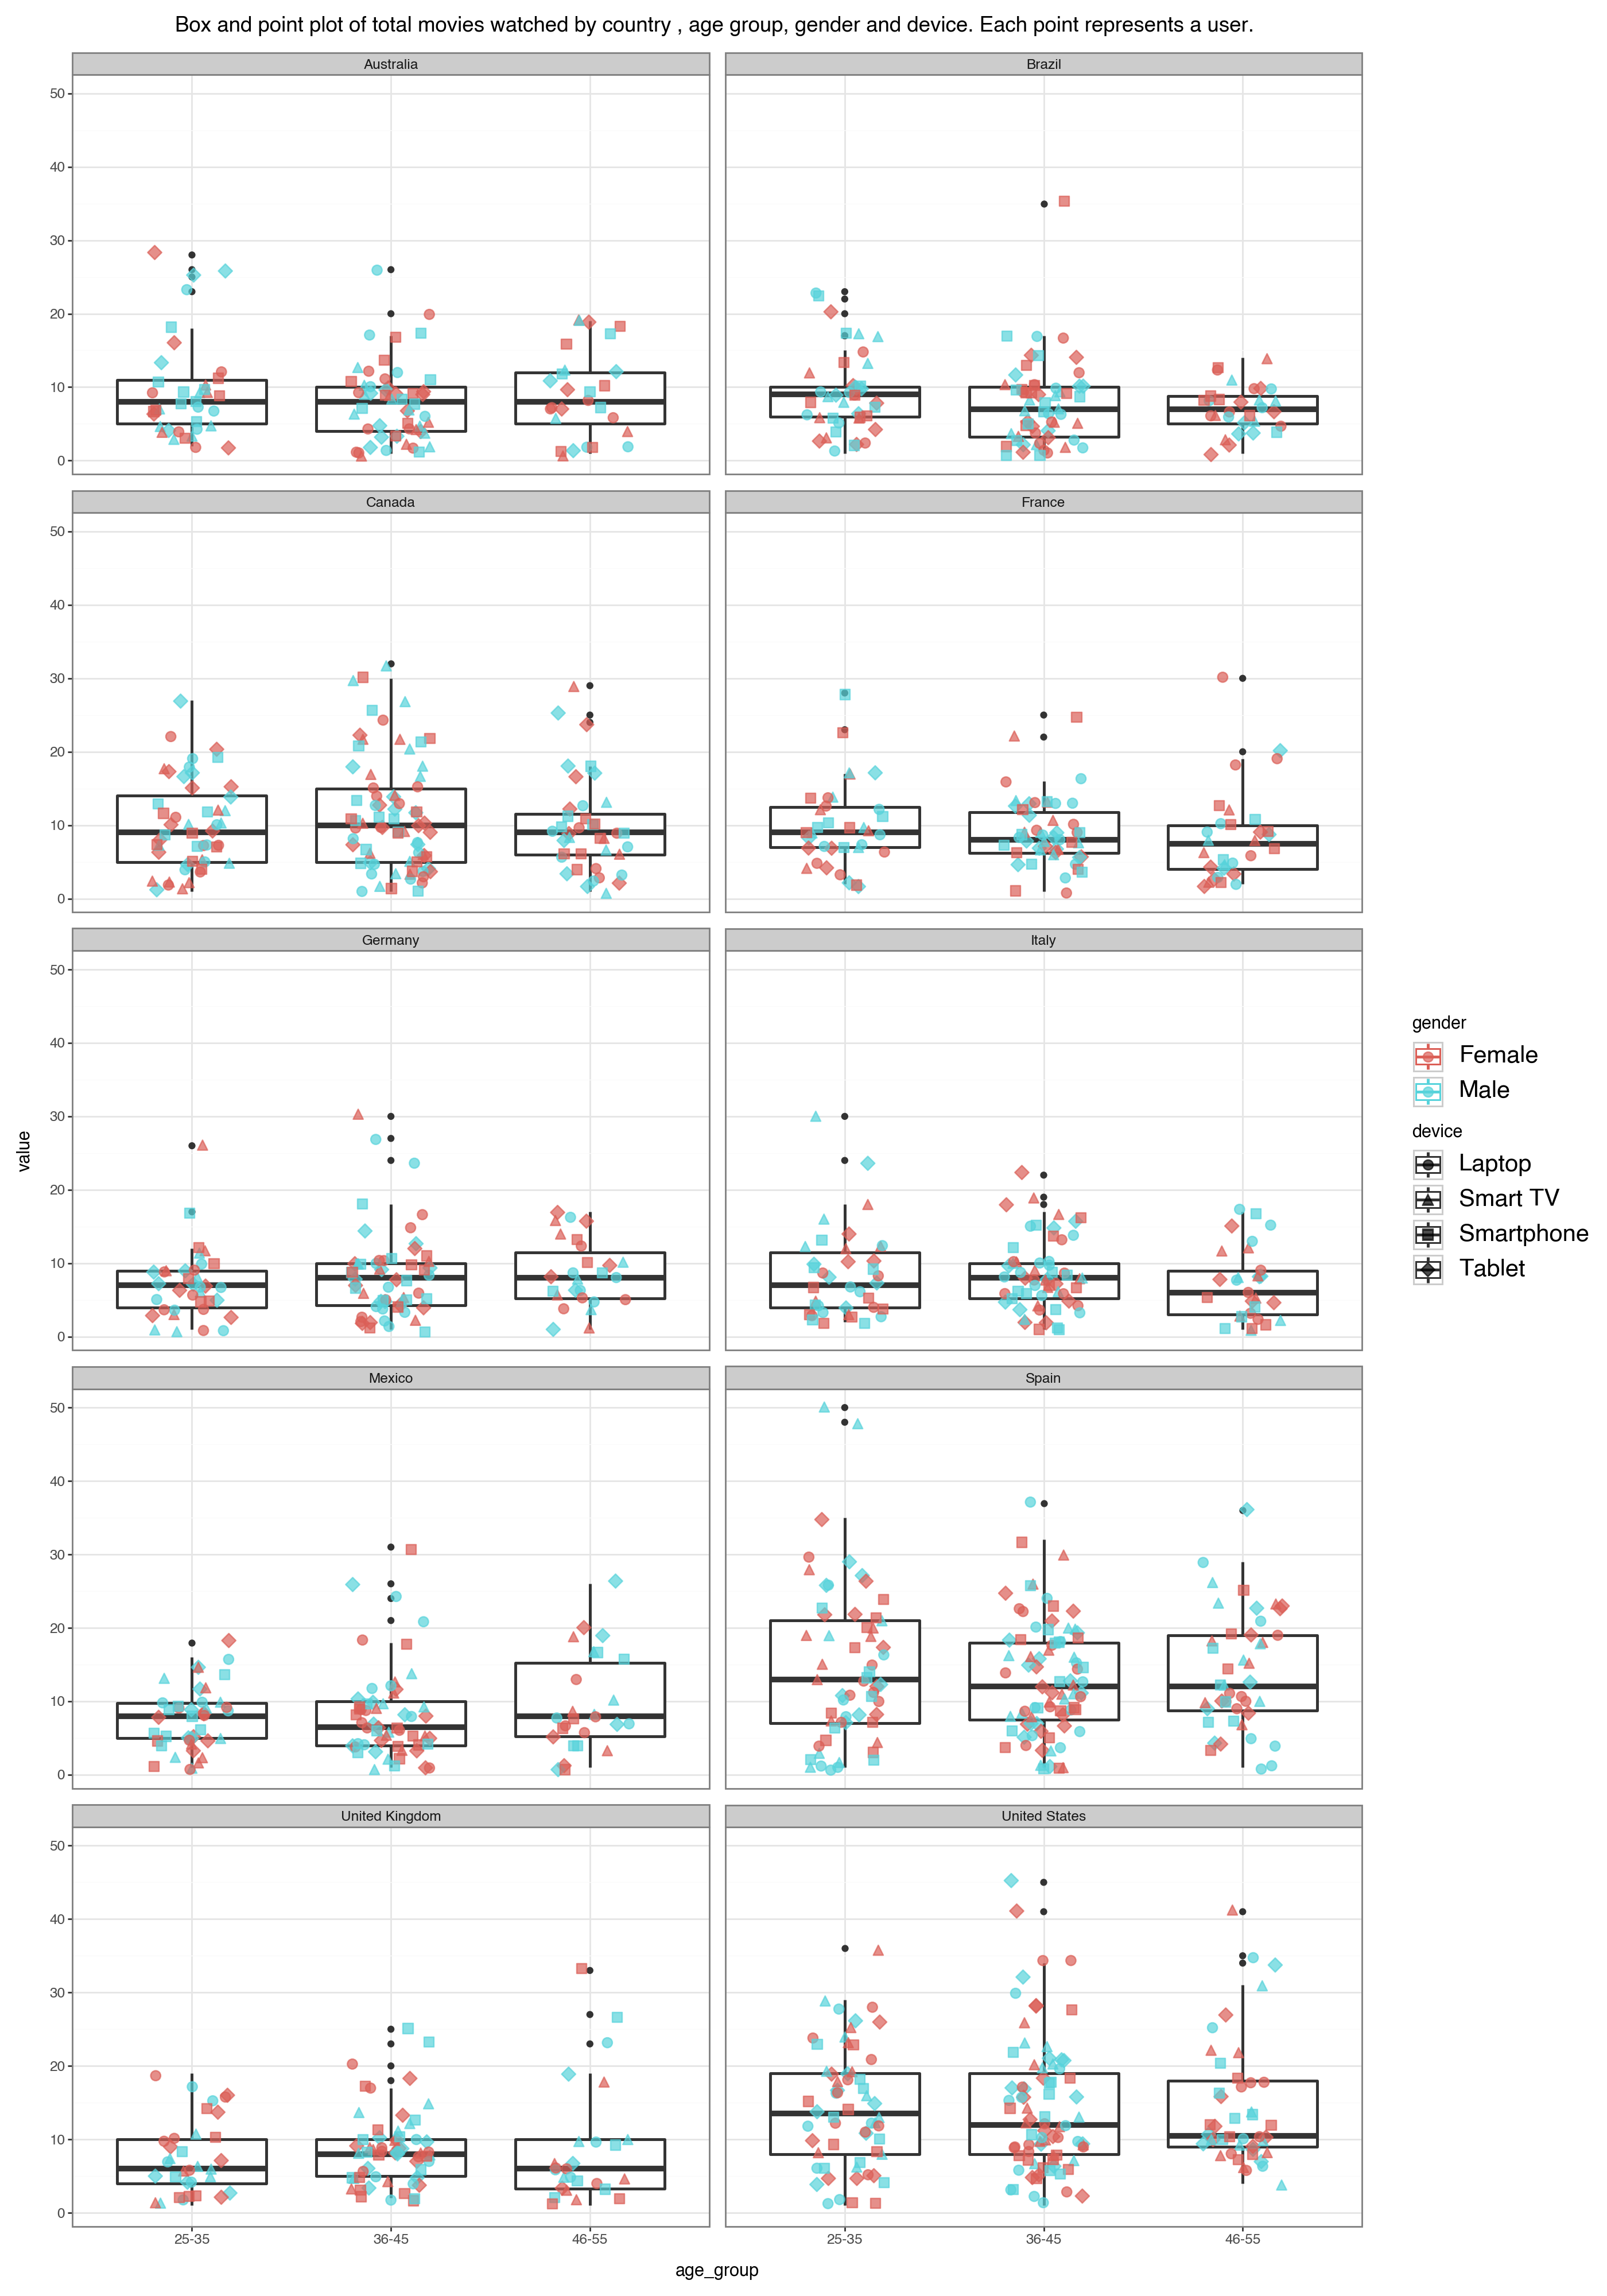

In [55]:
# filter out two cases of age above 100
from IPython.display import display, HTML

# Set the height in pixels
cell_height = 500

# Use HTML to adjust the cell height
display(HTML(f"<style>.output_wrapper, .output {{ height: {cell_height}px; }}</style>"))


options.figure_size = (14,20)
plot_df = res_df.copy()
plot_df = plot_df.loc[plot_df.age <100,:]

plot_df = plot_df.melt(["country", "gender", "device", "age_group", "age"])
plot_df = plot_df.loc[plot_df.variable == "total_movies_watched",:]

p = (
    ggplot(plot_df.dropna(), aes(x="age_group", y="value", color="gender", shape="device", group="age_group")) +
    facet_wrap(["country"], ncol=2) +
    geom_boxplot(size=1, position=position_dodge(width=3)) +
    geom_point(position=position_jitter(width=0.2), alpha=0.7, size=3) +  # Increase the size of the shape inside the legend key
    theme_bw() +
    theme(legend_text=element_text(size=15), legend_key_size=20)  + ggtitle("Box and point plot of total movies watched by country , age group, gender and device. Each point represents a user. ")
)

p



The above boxplot gives indication of the following:
- The averages between age groups are simila. Country wise, it is noticable that the median for all groups (shown as the center line of a boxplot), is higher in the U.S than in other countres (with the expception of Spain). U.S is also the country with the most data.
- It's not clear from these age groups that men are watching movies more than women (in the same age group).

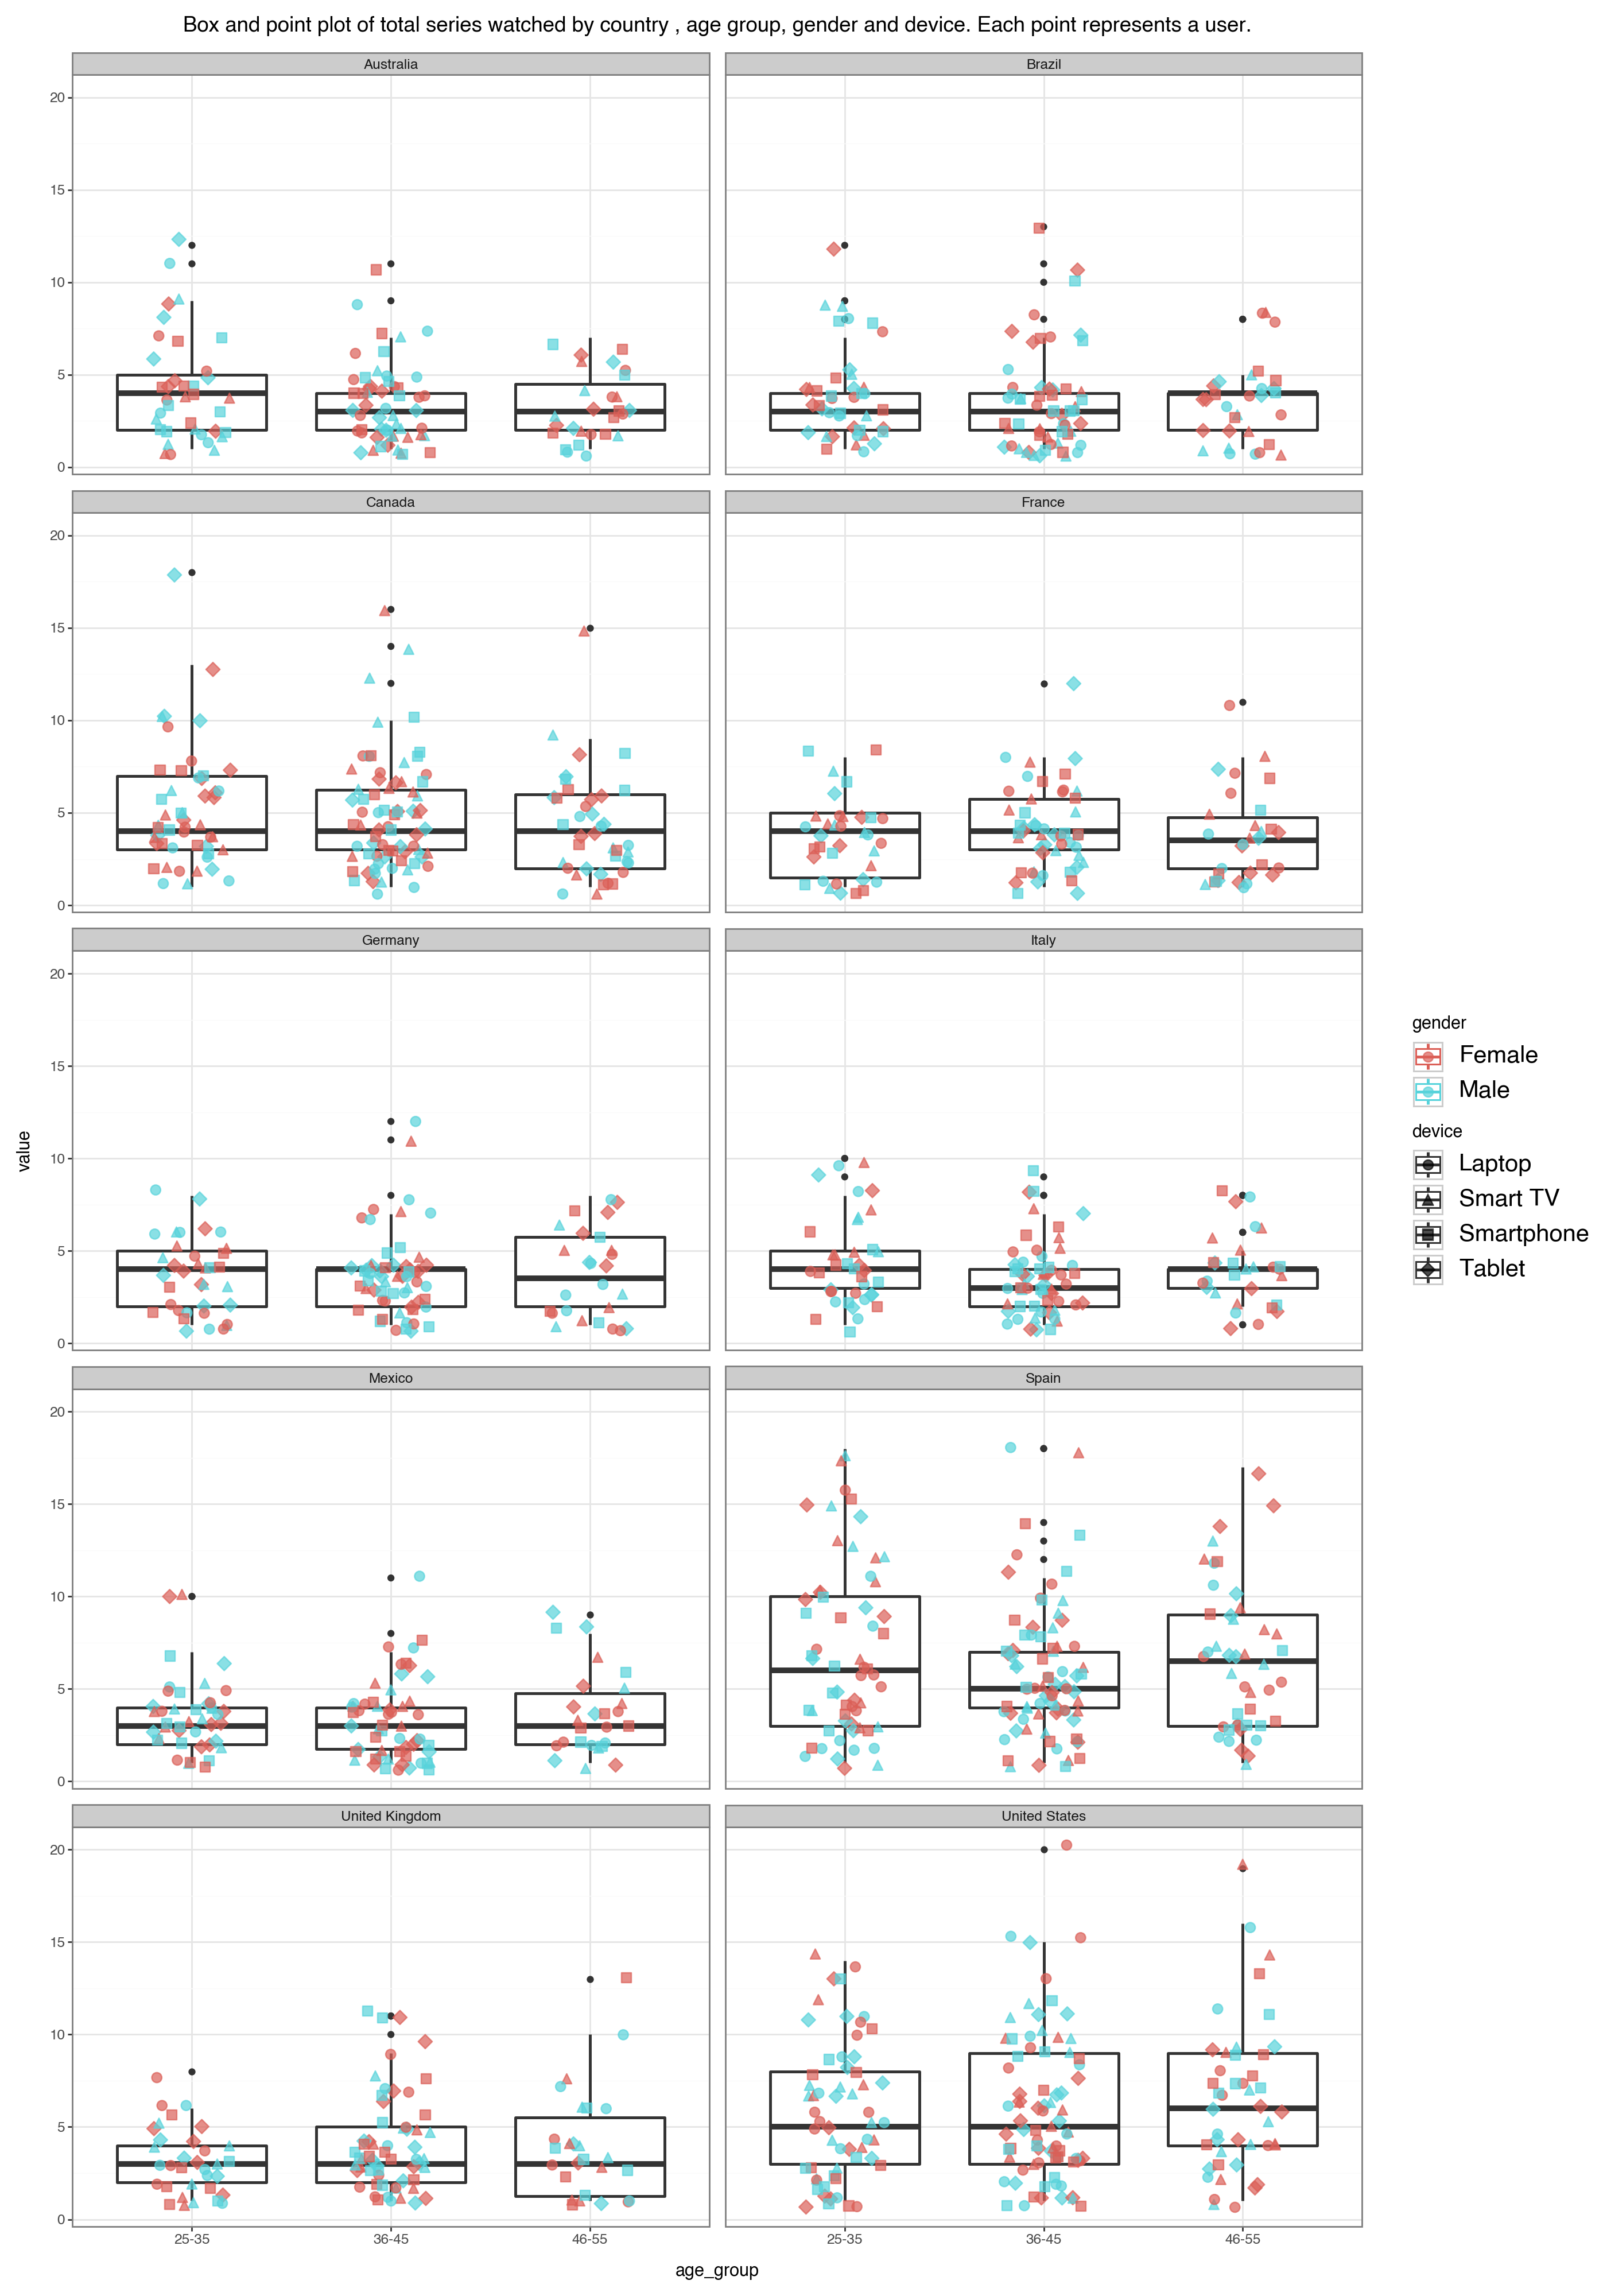

In [56]:
# filter out two cases of age above 100

from IPython.display import display, HTML

# Set the height in pixels
cell_height = 500

# Use HTML to adjust the cell height
display(HTML(f"<style>.output_wrapper, .output {{ height: {cell_height}px; }}</style>"))


options.figure_size = (14,20)
plot_df = res_df.copy()
plot_df = plot_df.loc[plot_df.age <100,:]

plot_df = plot_df.melt(["country", "gender", "device", "age_group", "age"])
plot_df = plot_df.loc[plot_df.variable == "total_series_watched",:]

p = (
    ggplot(plot_df.dropna(), aes(x="age_group", y="value", color="gender", shape="device", group="age_group")) +
    facet_wrap(["country"], ncol=2) +
    geom_boxplot(size=1, position=position_dodge(width=3)) +
    geom_point(position=position_jitter(width=0.2), alpha=0.7, size=3) +  # Increase the size of the shape inside the legend key
    theme_bw() +
    theme(legend_text=element_text(size=15), legend_key_size=20)  + ggtitle("Box and point plot of total series watched by country , age group, gender and device. Each point represents a user.")# Increase the size of the legend key
)

p



The above boxplot gives indication of the following:
- The averages between age groups are higher for U.S and Spain, as in the case for movies.
- The variance is quite high for Spain in the younger and older age group
  

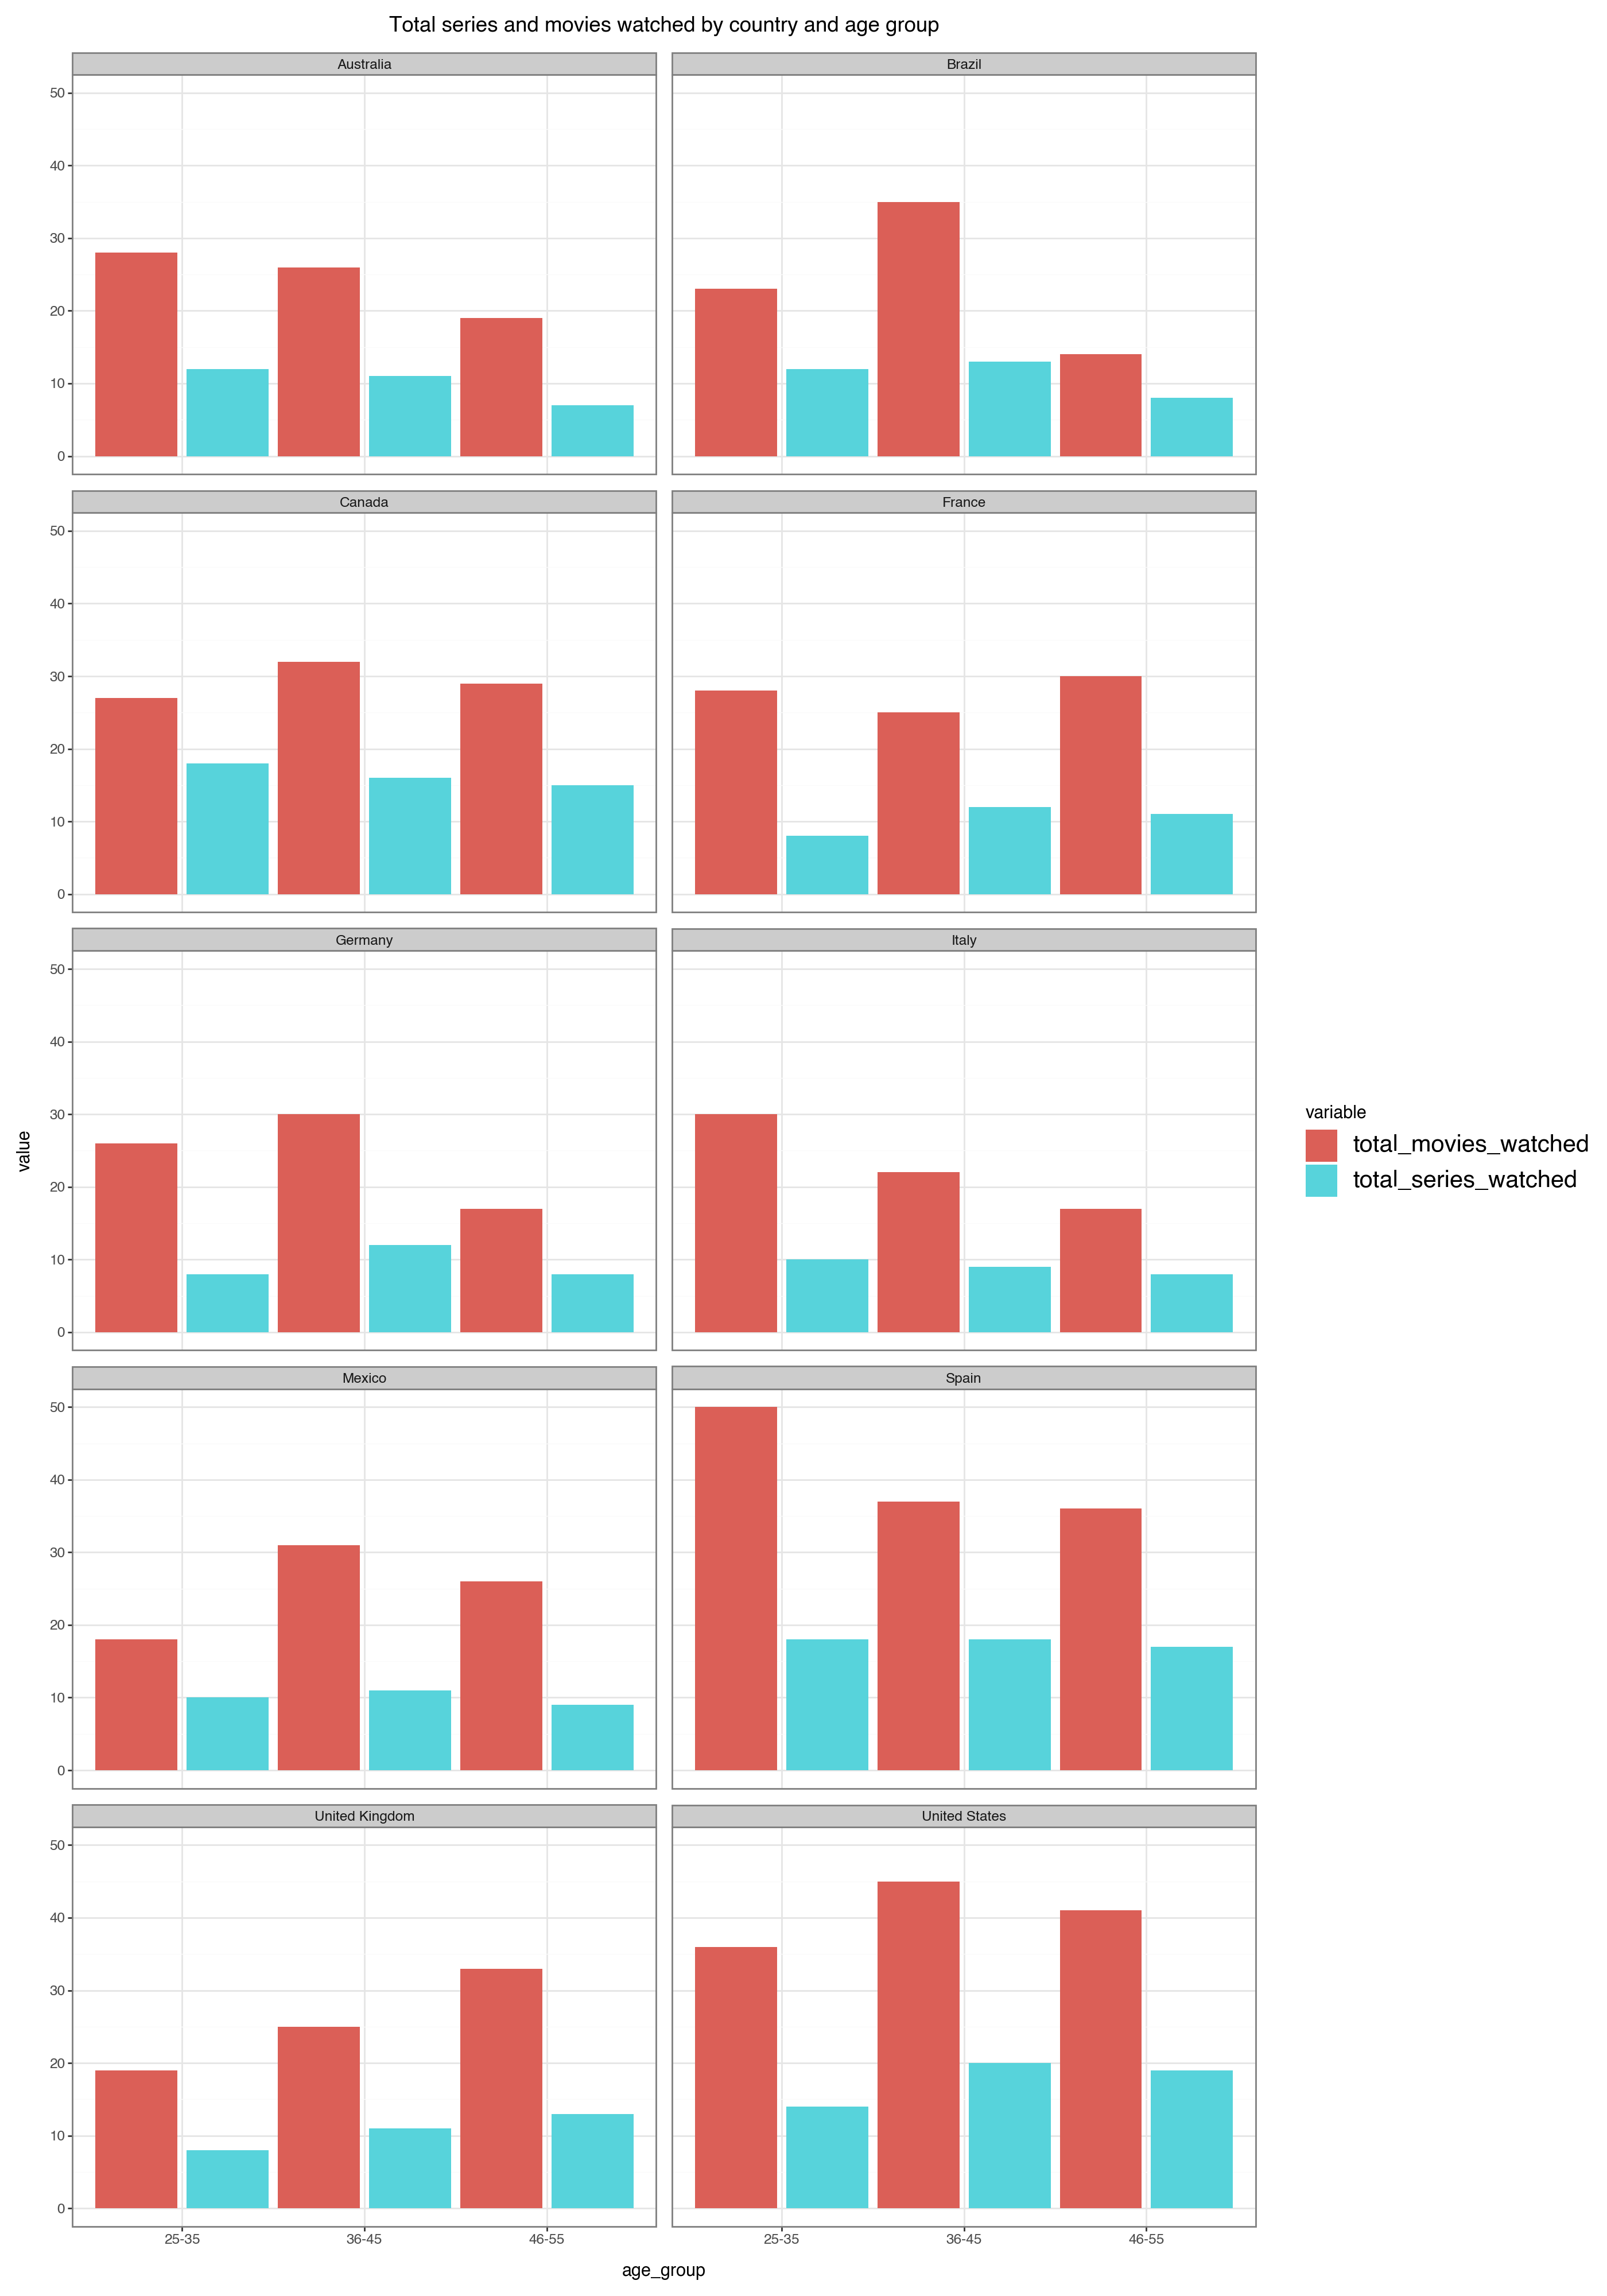

In [57]:
# Comparitve analysis

from IPython.display import display, HTML

# Set the height in pixels
cell_height = 500

# Use HTML to adjust the cell height
display(HTML(f"<style>.output_wrapper, .output {{ height: {cell_height}px; }}</style>"))


options.figure_size = (14,20)
plot_df = res_df.copy()
plot_df = plot_df.loc[plot_df.age <100,:]

plot_df = plot_df.melt(["country", "gender", "device", "age_group", "age"])
#plot_df = plot_df.loc[plot_df.variable == "total_series_watched",:]

# .sort_values(["country","age_group", "gender"])

p = (
    ggplot(plot_df.dropna(), aes(x="age_group", y="value", opacity = "gender", fill = "variable", group = "variable")) +
    facet_wrap(["country"], ncol=2) +
    geom_bar(stat = "identity", position=position_dodge(width=1.0) ) + 
    theme_bw() +
    theme(legend_text=element_text(size=15), legend_key_size=20) +
    ggtitle("Total series and movies watched by country and age group")
)

p

The above plot illustrates the folloowing:
- As expected, the count of movies watched is higher than that of series watched
- The age group total for movies watched can vary quite signficantly between different countries. For instance in Spain, the lowest age group has the highest movies watched , whereas in the U.K, it's the opposite. In Brazil, the middle age group is distinctevely a more movie weatching group than the rest. 